# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [1]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Vector{Float64}:
 0.37543455551961435
 0.2816036068612682
 0.847049820353683
 0.5242105864391282
 0.5097688163549111
 0.3927805712913428
 0.8064447339447157
 0.37689990764469794
 0.08828310860422894
 0.5786950511405645
 0.3927086229343111
 0.6007602300571618
 0.13460050281515157
 ⋮
 0.8654409756775755
 0.31958277582886907
 0.6836979423954249
 0.38799574536876724
 0.28786790634386905
 0.0927546421385067
 0.31576591281339794
 0.6698124054648549
 0.7454069712068929
 0.8333625075582902
 0.411249965787466
 0.09472347522394597

In [2]:
sum(a)

5.000842236543974e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [3]:
@time sum(a)

  0.006766 seconds (1 allocation: 16 bytes)


5.000842236543974e6

In [4]:
@time sum(a)

  0.007465 seconds (1 allocation: 16 bytes)


5.000842236543974e6

In [5]:
@time sum(a)

  0.006944 seconds (1 allocation: 16 bytes)


5.000842236543974e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [6]:
using Pkg
Pkg.add("BenchmarkTools")

   Resolving package versions...
  No Changes to `~/julia/Introduction-to-Julia/Project.toml`
  No Changes to `~/julia/Introduction-to-Julia/Manifest.toml`


In [7]:
using BenchmarkTools  

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [11]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [12]:
c_sum(a)

5.000842236543463e6

In [13]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [14]:
c_sum(a) - sum(a)  

-5.112960934638977e-7

In [15]:
≈  # alias for the `isapprox` function

isapprox (generic function with 13 methods)

In [16]:
?isapprox

search: isapprox



```
isapprox(x, y; atol::Real=0, rtol::Real=atol>0 ? 0 : √eps, nans::Bool=false[, norm::Function])
```

Inexact equality comparison. Two numbers compare equal if their relative distance *or* their absolute distance is within tolerance bounds: `isapprox` returns `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` (absolute tolerance) is zero and the default `rtol` (relative tolerance) depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significant digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

The `norm` keyword defaults to `abs` for numeric `(x,y)` and to `LinearAlgebra.norm` for arrays (where an alternative `norm` choice is sometimes useful). When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

!!! compat "Julia 1.6"
    Passing the `norm` keyword argument when comparing numeric (non-array) arguments requires Julia 1.6 or later.


# Examples

```jldoctest
julia> isapprox(0.1, 0.15; atol=0.05)
true

julia> isapprox(0.1, 0.15; rtol=0.34)
true

julia> isapprox(0.1, 0.15; rtol=0.33)
false

julia> 0.1 + 1e-10 ≈ 0.1
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0]) # using `norm`
true
```

---

```
isapprox(x; kwargs...) / ≈(x; kwargs...)
```

Create a function that compares its argument to `x` using `≈`, i.e. a function equivalent to `y -> y ≈ x`.

The keyword arguments supported here are the same as those in the 2-argument `isapprox`.

!!! compat "Julia 1.5"
    This method requires Julia 1.5 or later.



We can now benchmark the C code directly from Julia:

In [17]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 442 samples with 1 evaluation.
 Range (min … max):  10.913 ms …  15.824 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     11.080 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   11.303 ms ± 623.061 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▅▅▄▂ ▁  ▁▄▂▂                                                 
  ███████▄▇████▇▅▅▄▄▅▇▄▁▄▆▄▁▅▅▁▅▄▄▄▆▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅ ▇
  10.9 ms       Histogram: log(frequency) by time      14.7 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [18]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 10.913398 msec


In [19]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 1 entry:
  "C" => 10.9134

In [20]:
using Plots
gr()

Plots.GRBackend()

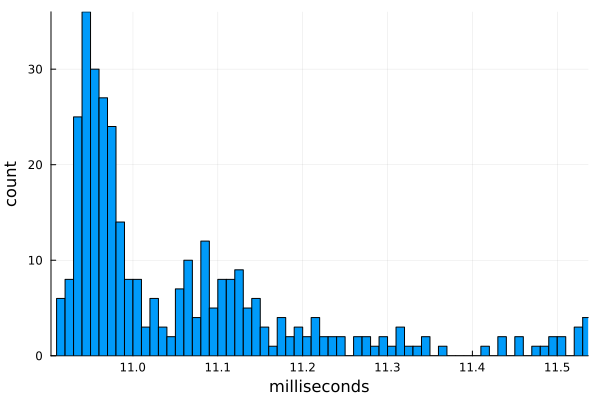

In [21]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. C with -ffast-math

If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.

In [22]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [23]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 712 samples with 1 evaluation.
 Range (min … max):  6.535 ms …  11.291 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     6.745 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   7.020 ms ± 663.029 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ██▇▄▂▃▃▃▂▂      ▃▂▂                                         
  ▇████████████▇▇▆█████▆▅▁▅▅▁▅▄▅▁▆▅▄▄▄▁▄▅▁▁▅▁▄▁▄▁▄▄▅▁▄▄▄▁▁▁▁▄ █
  6.53 ms      Histogram: log(frequency) by time      10.1 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [24]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

6.534876

# 3. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [25]:
using Pkg; Pkg.add("PyCall")
using PyCall

   Resolving package versions...
  No Changes to `~/julia/Introduction-to-Julia/Project.toml`
  No Changes to `~/julia/Introduction-to-Julia/Manifest.toml`


In [26]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [27]:
pysum(a)

5.000842236543463e6

In [28]:
pysum(a) ≈ sum(a)

true

In [29]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 8 samples with 1 evaluation.
 Range (min … max):  668.397 ms … 689.027 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     677.737 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   678.142 ms ±   7.274 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █  █                █ █         █    █             █        █  
  █▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁█▁▁▁▁▁▁▁▁▁█▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁█ ▁
  668 ms           Histogram: frequency by time          689 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [30]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"               => 10.9134
  "Python built-in" => 668.397
  "C -ffast-math"   => 6.53488

# 4. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [31]:
using Pkg; Pkg.add("Conda")
using Conda

   Resolving package versions...
  No Changes to `~/julia/Introduction-to-Julia/Project.toml`
  No Changes to `~/julia/Introduction-to-Julia/Manifest.toml`


In [ ]:
Conda.add("numpy")

[ Info: Downloading miniconda installer ...


PREFIX=/home/nuc1/.julia/conda/3/x86_64


[ Info: Installing miniconda ...


Unpacking payload ...
Extracting _libgcc_mutex-0.1-conda_forge.tar.bz2
Extracting ca-certificates-2023.11.17-hbcca054_0.conda
Extracting ld_impl_linux-64-2.40-h41732ed_0.conda
Extracting libstdcxx-ng-13.2.0-h7e041cc_3.conda
Extracting pybind11-abi-4-hd8ed1ab_3.tar.bz2
Extracting python_abi-3.10-4_cp310.conda
Extracting tzdata-2023c-h71feb2d_0.conda
Extracting libgomp-13.2.0-h807b86a_3.conda
Extracting _openmp_mutex-4.5-2_gnu.tar.bz2
Extracting libgcc-ng-13.2.0-h807b86a_3.conda
Extracting bzip2-1.0.8-hd590300_5.conda
Extracting c-ares-1.24.0-hd590300_0.conda
Extracting fmt-10.1.1-h00ab1b0_1.conda
Extracting icu-73.2-h59595ed_0.conda
Extracting keyutils-1.6.1-h166bdaf_0.tar.bz2
Extracting libev-4.33-hd590300_2.conda
Extracting libffi-3.4.2-h7f98852_5.tar.bz2
Extracting libiconv-1.17-hd590300_2.conda
Extracting libnsl-2.0.1-hd590300_0.conda
Extracting libuuid-2.38.1-h0b41bf4_0.conda
Extracting libzlib-1.2.13-hd590300_5.conda
Extracting lz4-c-1.9.4-hcb278e6_0.conda
Extracting lzo-2.10-h516

[ Info: Running `conda install -y numpy` in root environment


In [ ]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

In [ ]:
numpy_sum(a)

In [ ]:
numpy_sum(a) ≈ sum(a)

In [ ]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

# 5. Python, hand-written 

In [35]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x7ff7d13c8b80>

In [36]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  1.012 s …  1.027 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.018 s             ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.019 s ± 6.023 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █       █              █        █                      █  
  █▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  110 s         Histogram: frequency by time         130 s <

 Memory estimate: 336 bytes, allocs estimate: 6.

In [37]:
sum_py(a)

5.000406093458116e6

In [38]:
sum_py(a) ≈ sum(a)

true

In [39]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "C"                   => 9.38288
  "Python numpy"        => 1.91263
  "Python hand-written" => 1011.92
  "Python built-in"     => 875.812
  "C -ffast-math"       => 1.78121

# 6. Julia (built-in) 

## Written directly in Julia, not in C!

In [40]:
@which sum(a)

sum(a::AbstractArray; dims, kw...) in Base at reducedim.jl:873

In [41]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 2387 samples with 1 evaluation.
 Range (min … max):  1.861 ms …   6.781 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.980 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.074 ms ± 274.199 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▂█▃                                                         
  ▃███▇▆▅▄▅▅▅▅▄▃▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂ ▃
  1.86 ms         Histogram: frequency by time         370 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [42]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any, Any} with 6 entries:
  "C"                   => 9.38288
  "Python numpy"        => 1.91263
  "Python hand-written" => 1011.92
  "Python built-in"     => 875.812
  "Julia built-in"      => 1.8605
  "C -ffast-math"       => 1.78121

# 7. Julia (hand-written) 

In [43]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [44]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 510 samples with 1 evaluation.
 Range (min … max):  9.387 ms …  13.864 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     9.651 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.793 ms ± 471.368 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▂█▄  ▃                                                       
  ███████▇▇▆▅▅▄▅▆▄▄▅▄▄▄▄▃▃▂▃▃▁▃▂▂▃▂▂▂▁▁▁▁▂▁▁▂▁▁▂▁▁▁▂▁▂▂▁▁▁▂▂▂ ▃
  9.39 ms         Histogram: frequency by time        11.7 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [45]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any, Any} with 7 entries:
  "C"                   => 9.38288
  "Python numpy"        => 1.91263
  "Julia hand-written"  => 9.387
  "Python hand-written" => 1011.92
  "Python built-in"     => 875.812
  "Julia built-in"      => 1.8605
  "C -ffast-math"       => 1.78121

# 8. Julia (hand-written w. simd) 

In [46]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [47]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 2023 samples with 1 evaluation.
 Range (min … max):  2.370 ms …  3.173 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.429 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.454 ms ± 67.874 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

        █▇▆▅▄▄▃▃▃▃▂▂▂▂    ▁ ▁▁                               ▁
  █▄▆██████████████████████▇██▇▆▇▆▇▆▆▆▆▆▄▆▅▆▅▆▄▄▁▄▄▄▄▄▄▅▄▄▄▄ █
  2.37 ms      Histogram: log(frequency) by time     2.76 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [48]:
mysum_simd(a)

5.000406093458086e6

In [49]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any, Any} with 8 entries:
  "Julia hand-written simd" => 2.37012
  "C"                       => 9.38288
  "Python numpy"            => 1.91263
  "Julia hand-written"      => 9.387
  "Python hand-written"     => 1011.92
  "Python built-in"         => 875.812
  "Julia built-in"          => 1.8605
  "C -ffast-math"           => 1.78121

# Summary

In [50]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

C -ffast-math...............1.8
Julia built-in..............1.9
Python numpy................1.9
Julia hand-written simd.....2.4
C...........................9.4
Julia hand-written..........9.4
Python built-in...........875.8
Python hand-written......1011.9
